# Cluster Configuration Sandbox

For testing different dask-jobqueue configurations.

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import copy
import os
import sys
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
import timeit

import yaml
import numpy as np
import matplotlib.pyplot as plt
import dask
import distributed
import dask_jobqueue
from dask_jobqueue import PBSCluster
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
import ndcube
from scipy.optimize import curve_fit

import aiacube

sys.path.append('../scripts')
from colormaps import *

%matplotlib inline

## Cluster Setup

We want to send all of our computation off to the nodes in our cluster rather than this notebook. To do this, we first need to setup a Dask cluster.

In [2]:
with open('../config/jobqueue-pleiades-ivy.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
config

{'cores': 10,
 'processes': 1,
 'memory': '64GB',
 'interface': 'ib0',
 'resource_spec': 'select=1:ncpus=20:model=ivy',
 'walltime': '00:30:00',
 'queue': 'normal',
 'local_directory': '/nobackupp13/wtbarnes/dask-tmp',
 'log_directory': '/nobackupp13/wtbarnes/dask-tmp'}

In [3]:
n_nodes = 2
n_cores_per_node = 20
memory_per_core = 64*u.GB 
config['resource_spec'] = f'select={n_nodes}:ncpus={n_cores_per_node}:model=ivy'
config['cores'] = n_nodes * n_cores_per_node
config['processes'] = n_nodes
config['memory'] = f'{(n_nodes * memory_per_core).to(u.GB).value:.0f}GB'
config['walltime'] = '00:15:00'
config['queue'] = 'devel'

In [4]:
config

{'cores': 40,
 'processes': 2,
 'memory': '128GB',
 'interface': 'ib0',
 'resource_spec': 'select=2:ncpus=20:model=ivy',
 'walltime': '00:15:00',
 'queue': 'devel',
 'local_directory': '/nobackupp13/wtbarnes/dask-tmp',
 'log_directory': '/nobackupp13/wtbarnes/dask-tmp'}

In [5]:
cluster = PBSCluster(**config)

*(**NOTE:** This setup may need to be customized depending on the hardware you're using. The above configuration is for Merope and is read from the configuration file in `$HOME/.config/dask/jobqueue.yml`.)*

In [6]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q devel
#PBS -l select=2:ncpus=20:model=ivy
#PBS -l walltime=00:15:00
#PBS -e /nobackupp13/wtbarnes/dask-tmp/
#PBS -o /nobackupp13/wtbarnes/dask-tmp/
JOB_ID=${PBS_JOBID%%.*}

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/bin/python -m distributed.cli.dask_worker tcp://10.148.15.187:46813 --nthreads 20 --nprocs 2 --memory-limit 64.00GB --name name --nanny --death-timeout 60 --local-directory /nobackupp13/wtbarnes/dask-tmp --interface ib0



Then, create a client for the cluster.

In [7]:
client = distributed.Client(cluster)

Note that the Dask cluster, unlike traditional HPC schedulers (e.g. PBS) is not persistent, meaning we need to create it each time we start our analysis.

Lastly, we'll add some workers to our cluster so that we can actually do some computation!

In [8]:
client

<Client: 'tcp://10.148.15.187:46813' processes=0 threads=0, memory=0 B>

In [9]:
cluster.scale(jobs=1)

## Example Calculation

In [10]:
subcube_94 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 94*u.angstrom)

In [11]:
subcube_171 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 171*u.angstrom)

In [12]:
subcube_94_rechunk = subcube_94.rechunk(
    subcube_94.data.shape[:1] + (50, 50))

In [13]:
subcube_171_rechunk = subcube_171.rechunk(
    subcube_171.data.shape[:1] + (50, 50))

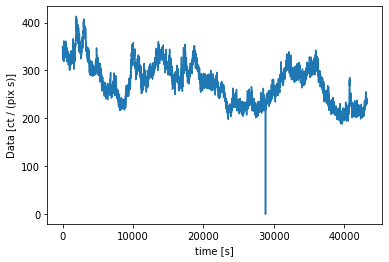

In [14]:
subcube_171_rechunk[:,350,350].plot()

In [16]:
tl_map = aiacube.time_lag_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    timelag_bounds=(-3*u.h, 3*u.h),
)

In [23]:
tl_map.data

dask.array<reshape, shape=(752, 752), dtype=float64, chunksize=(5, 752), chunktype=astropy.Quantity>

DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ffec88ee908>
DEBUG:Using auto colorbar locator on colorbar
DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ffec88ee908>
DEBUG:Setting pcolormesh


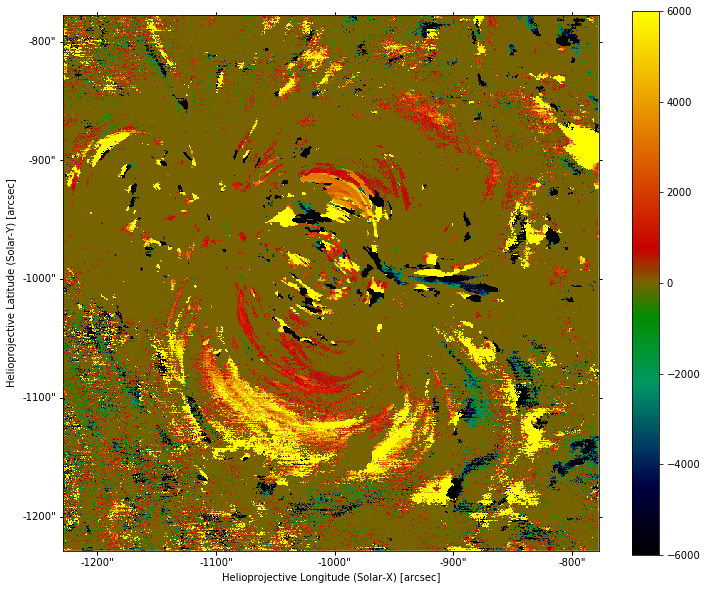

In [16]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_map)
im = tl_map.plot(
    axes=ax,
    vmin=-(6e3*u.s).to(u.s).value,
    vmax=(6e3*u.s).to(u.s).value,
    cmap='idl_bgry_004',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

In [15]:
maxcc_map = aiacube.peak_cross_correlation_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    timelag_bounds=(-3*u.h, 3*u.h),
)

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=maxcc_map)
im = maxcc_map.plot(
    axes=ax,
    vmin=0,
    vmax=1,
    cmap='magma',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

In [41]:
time_cc = %timeit -o -n 1 -r 1 maxcc_map.data.compute()

24.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
time_cc.average

24.98760731506627

In [43]:
jobs = [100, 50, 20, 10, 5, 2, 1]

In [44]:
compute_time = []
for j in jobs:
    cluster.scale(j)
    while len(cluster.workers) != j:
        pass
    ct = %timeit -o -n 1 -r 1 maxcc_map.data.compute()
    compute_time.append(ct.average)

DEBUG:Job script: 
 #!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q normal
#PBS -l select=1:ncpus=20:model=ivy
#PBS -l walltime=00:30:00
#PBS -e /nobackupp13/wtbarnes/dask-tmp/
#PBS -o /nobackupp13/wtbarnes/dask-tmp/
JOB_ID=${PBS_JOBID%%.*}

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/bin/python -m distributed.cli.dask_worker tcp://10.148.15.187:42751 --nthreads 10 --memory-limit 64.00GB --name name --nanny --death-timeout 60 --local-directory /nobackupp13/wtbarnes/dask-tmp --interface ib0

DEBUG:Job script: 
 #!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q normal
#PBS -l select=1:ncpus=20:model=ivy
#PBS -l walltime=00:30:00
#PBS -e /nobackupp13/wtbarnes/dask-tmp/
#PBS -o /nobackupp13/wtbarnes/dask-tmp/
JOB_ID=${PBS_JOBID%%.*}

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/bin/python -m distributed.cli.dask_worker tcp://10.148.15.187:42751 --nthreads 10 --memory-limit 64.00GB --name name --nanny --death-timeout 60 --local-directory /nobackupp13/wtbarnes/dask-tmp --interface ib0

24.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 111 job: 7602137
DEBUG:Executing the following command to command line
qdel 7602137
DEBUG:Closed job 7602137
DEBUG:Stopping worker: 75 job: 7602153
DEBUG:Executing the following command to command line
qdel 7602153
DEBUG:Closed job 7602153
DEBUG:Stopping worker: 106 job: 7602109
DEBUG:Executing the following command to command line
qdel 7602109
DEBUG:Closed job 7602109
DEBUG:Stopping worker: 86 job: 7602112
DEBUG:Executing the following command to command line
qdel 7602112
DEBUG:Closed job 7602112
DEBUG:Stopping worker: 87 job: 7602155
DEBUG:Executing the following command to command line
qdel 7602155
DEBUG:Closed job 7602155
DEBUG:Stopping worker: 104 job: 7602103
DEBUG:Executing the following command to command line
qdel 7602103
DEBUG:Closed job 7602103
DEBUG:Stopping worker: 116 job: 7602113
DEBUG:Executing the following command to command line
qdel 7602113
DEBUG:Closed job 7602113
DEBUG:Stopping worker: 74 job: 7602147
DEBUG:Executing the following command to

28.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 34 job: 7602018
DEBUG:Executing the following command to command line
qdel 7602018
DEBUG:Closed job 7602018
DEBUG:Stopping worker: 41 job: 7602005
DEBUG:Executing the following command to command line
qdel 7602005
DEBUG:Closed job 7602005
DEBUG:Stopping worker: 38 job: 7602020
DEBUG:Executing the following command to command line
qdel 7602020
DEBUG:Closed job 7602020
DEBUG:Stopping worker: 31 job: 7602016
DEBUG:Executing the following command to command line
qdel 7602016
DEBUG:Closed job 7602016
DEBUG:Stopping worker: 30 job: 7602021
DEBUG:Executing the following command to command line
qdel 7602021
DEBUG:Closed job 7602021
DEBUG:Stopping worker: 43 job: 7601992
DEBUG:Executing the following command to command line
qdel 7601992
DEBUG:Closed job 7601992
DEBUG:Stopping worker: 44 job: 7602013
DEBUG:Executing the following command to command line
qdel 7602013
DEBUG:Closed job 7602013
DEBUG:Stopping worker: 58 job: 7602102
DEBUG:Executing the following command to com

33.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 26 job: 7601994
DEBUG:Executing the following command to command line
qdel 7601994
DEBUG:Closed job 7601994
DEBUG:Stopping worker: 20 job: 7601988
DEBUG:Executing the following command to command line
qdel 7601988
DEBUG:Closed job 7601988
DEBUG:Stopping worker: 19 job: 7601997
DEBUG:Executing the following command to command line
qdel 7601997
DEBUG:Closed job 7601997
DEBUG:Stopping worker: 25 job: 7602032
DEBUG:Executing the following command to command line
qdel 7602032
DEBUG:Closed job 7602032
DEBUG:Stopping worker: 23 job: 7602007
DEBUG:Executing the following command to command line
qdel 7602007
DEBUG:Closed job 7602007
DEBUG:Stopping worker: 24 job: 7602024
DEBUG:Executing the following command to command line
qdel 7602024
DEBUG:Closed job 7602024
DEBUG:Stopping worker: 27 job: 7602011
DEBUG:Executing the following command to command line
qdel 7602011
DEBUG:Closed job 7602011
DEBUG:Stopping worker: 22 job: 7602031
DEBUG:Executing the following command to com

44.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 15 job: 7601998
DEBUG:Executing the following command to command line
qdel 7601998
DEBUG:Closed job 7601998
DEBUG:Stopping worker: 14 job: 7602017
DEBUG:Executing the following command to command line
qdel 7602017
DEBUG:Closed job 7602017
DEBUG:Stopping worker: 16 job: 7602002
DEBUG:Executing the following command to command line
qdel 7602002
DEBUG:Closed job 7602002
DEBUG:Stopping worker: 18 job: 7602027
DEBUG:Executing the following command to command line
qdel 7602027
DEBUG:Closed job 7602027
DEBUG:Stopping worker: 17 job: 7601985
DEBUG:Executing the following command to command line
qdel 7601985
DEBUG:Closed job 7601985
DEBUG:Executing the following command to command line
qdel 7602017
DEBUG:Closed job 7602017
DEBUG:Executing the following command to command line
qdel 7601998
DEBUG:Closed job 7601998
DEBUG:Executing the following command to command line
qdel 7602002
DEBUG:Closed job 7602002
DEBUG:Executing the following command to command line
qdel 7601985
DE

1min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 12 job: 7602023
DEBUG:Executing the following command to command line
qdel 7602023
DEBUG:Closed job 7602023
DEBUG:Stopping worker: 13 job: 7601987
DEBUG:Executing the following command to command line
qdel 7601987
DEBUG:Closed job 7601987
DEBUG:Stopping worker: 11 job: 7602015
DEBUG:Executing the following command to command line
qdel 7602015
DEBUG:Closed job 7602015
DEBUG:Executing the following command to command line
qdel 7602015
DEBUG:Closed job 7602015
DEBUG:Executing the following command to command line
qdel 7602023
DEBUG:Closed job 7602023
DEBUG:Executing the following command to command line
qdel 7601987
DEBUG:Closed job 7601987
DEBUG:Job script: 
 #!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q normal
#PBS -l select=1:ncpus=20:model=ivy
#PBS -l walltime=00:30:00
#PBS -e /nobackupp13/wtbarnes/dask-tmp/
#PBS -o /nobackupp13/wtbarnes/dask-tmp/
JOB_ID=${PBS_JOBID%%.*}

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/bin/python -m distributed.cli.dask_worke

2min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


DEBUG:Stopping worker: 10 job: 7601993
DEBUG:Executing the following command to command line
qdel 7601993
DEBUG:Closed job 7601993
DEBUG:Executing the following command to command line
qdel 7601993
DEBUG:Closed job 7601993


3min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [56]:
cores = np.array(jobs) * 10

In [72]:
ideal_scaling = lambda x: cores[-1] * compute_time[-1] / x

Text(0, 0.5, 'Compute Time [s]')

DEBUG:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG:vmin 7.943282347242816 vmax 1258

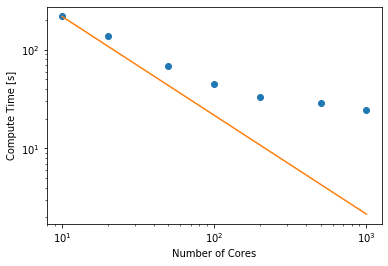

In [73]:
plt.plot(cores, compute_time, marker='o', ls='')
plt.plot(cores, ideal_scaling(cores))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Cores')
plt.ylabel('Compute Time [s]')